<a href="https://www.kaggle.com/code/kuntalpal/few-baselines-without-much-effort?scriptVersionId=115097228" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [27]:
%%capture
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Physics behind Protein Stability

**DDG** : Delta Delta G (DDG) is a metric for predicting how a single point mutation will affect protein stability. The thermodynamic stability change upon mutation is measured by ΔΔG(T$_{r}$), i.e. the difference between the standard Gibbs folding free energies of the mutant (ΔG$^{mut}$) and wild-type (ΔG$^{wild}$) proteins at the reference temperature T$_{r}$:

$$  ΔΔG(T_{r}) = (ΔG^{mut})(T_{r}) - (ΔG^{wild})(T_{r}) $$

In general,

$$ G = Enthalpy \ \  (H) - Temperature \ \ (T) \ x \ Entropy \ \ (S)  $$

H is the internal energy of a protein. H decreases during protein folding because folding will cause packing of hydrophobics, optimized polar group orientation, and achieves a good proximity to ideal bond lengths and angles. S is the measure of order within a system. S of a protein becomes lower during protein folding because residue dynamics will be significantly decreased in comparison the unfolded state. However, decrease is in protein S will also cause an increase in S for solvent. The energy of an unfolded protein is nearly identical with a single point mutation. So, the
dominant factor in DDG is the energy difference of the folded state.


DDG results will fall into three categories:

1. **DDG > 0.5**: Positive results suggest that a mutation would be destabilizing. Most mutations will be positive or close to zero because proteins have evolved to be reasonably stable. These mutations are residues that you should usually avoid during design.

2. Things that are near 0 are within the noise range so should be considered neutral.

3. DDG < -0.5: Negative results suggest that the mutation would lead to a more stable protein. However, the environment at each position should be considered.

    a. If interacting molecules are not present in the model, such as at a known zinc binding site, then a seemingly favorable mutation will not be favorable in reality.
    
    b. A positions that has a lot of negative DDGs could mean that this position evolved a destabilizing residue because it is necessary for its catalytic activity, for binding another molecule, or because of another functionally relevant reason.
    
    c. Also, consider that this measures a single point mutation. Many times it requires multiple interacting mutations in order to achieve significant stability.

# ESM-2

ESM-2 is a transformer-based language model, and uses an attention mechanism to learn interaction patterns between pairs of amino acids in the input sequence.

The larger the value of the attention, the more impactful would be any mutation at that location. So the melting temperature is inversely proportional to the sum of the contact attentions.

In [28]:
# # latest release
# !pip install fair-esm

In [29]:
# #set the edit_idx
# import pandas as pd, numpy as np, nltk
# from sklearn.model_selection import GroupKFold
# import torch
# import esm
#wt = "VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK"
#df_test = pd.read_csv("../input/novozymes-enzyme-stability-prediction/test.csv")
#df_test.loc[1169, 'protein_sequence'] = wt[:-1]+"!" #1169 is the same as wt

#df_test['edit_idx'] = df_test.apply(lambda x:[i for i in range(len(x['protein_sequence'])) if x['protein_sequence'][i] != wt[i]][0], axis = 1)


# # Load ESM-2 model
# model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
# batch_converter = alphabet.get_batch_converter()
# model.eval()  # disables dropout for deterministic results


# # Prepare data (first 2 sequences from ESMStructuralSplitDataset superfamily / 4)
# data = [
#     ("protein1", wt),
# ]
# batch_labels, batch_strs, batch_tokens = batch_converter(data)

# # Extract per-residue representations (on CPU)
# with torch.no_grad():
#     results = model(batch_tokens, repr_layers=[33], return_contacts=True)
# token_representations = results["representations"][33]

# # Generate per-sequence representations via averaging
# # NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
# sequence_representations = []
# for i, (_, seq) in enumerate(data):
#     sequence_representations.append(token_representations[i, 1 : len(seq) + 1].mean(0))

    
# #all the code above is from ESM QuickStart
# ac_sum = np.sum(np.array(results["contacts"][0]), axis=1) 
# test_df['tm'] = test_df.apply(lambda x:1/ac_sum[x['edit_idx']], axis = 1)  
# test_df[['seq_id', 'tm']].set_index("seq_id").to_csv("submission.csv")
#df_test

In [30]:
df_train = pd.read_csv('../input/nesp-public-train-sets/Q3214/Q3214_direct.csv')
df_train

,pdb_id,position,wild_type,mutant,ddg
0,1otrB,34,E,A,-0.07
1,1a5eA,121,L,R,-0.66
2,1rtbA,4,A,S,0.47
3,4lyzA,102,G,R,-0.38
4,1thqA,157,M,A,0.77
...,...,...,...,...,...
3209,2lzmA,42,A,K,3.70
3210,1yeaA,76,P,G,1.20
3211,1stnA,104,V,T,2.50
3212,2lzmA,71,V,A,1.50


In [ ]:
%%capture
!pip install Levenshtein
import math
import multiprocessing
import os
import sys

import Levenshtein
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.model_selection
import tensorflow as tf
from keras import layers, callbacks
from keras import models
from keras import optimizers
from sklearn.model_selection import GroupKFold
from keras.saving.save import load_model
from tqdm import tqdm

In [31]:

def gen_mutations(name, df,
                  wild="VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQ""RVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGT""NAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKAL""GSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK"):
    result = []
    for _, r in df.iterrows():
        ops = Levenshtein.editops(wild, r.protein_sequence)
        assert len(ops) <= 1
        if len(ops) > 0 and ops[0][0] == 'replace':
            idx = ops[0][1]
            result.append([ops[0][0], idx + 1, wild[idx], r.protein_sequence[idx]])
        elif len(ops) == 0:
            result.append(['same', 0, '', ''])
        elif ops[0][0] == 'insert':
            assert False, "Ups"
        elif ops[0][0] == 'delete':
            idx = ops[0][1]
            result.append(['delete', idx + 1, wild[idx], '-'])
        else:
            assert False, "Ups"

    df = pd.concat([df, pd.DataFrame(data=result, columns=['op', 'idx', 'wild', 'mutant'])], axis=1)
    df['mut'] = df[['wild', 'idx', 'mutant']].astype(str).apply(lambda v: ''.join(v), axis=1)
    df['name'] = name
    return df


df_test = gen_mutations('wildtypeA', pd.read_csv('../input/novozymes-enzyme-stability-prediction/test.csv'))
df_test

,seq_id,protein_sequence,pH,data_source,op,idx,wild,mutant,mut,name
0,31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,17,L,E,L17E,wildtypeA
1,31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,17,L,K,L17K,wildtypeA
2,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes,delete,17,L,-,L17-,wildtypeA
3,31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,18,K,C,K18C,wildtypeA
4,31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,18,K,F,K18F,wildtypeA
...,...,...,...,...,...,...,...,...,...,...
2408,33798,VPVNPEPDATSVENVILKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,16,A,I,A16I,wildtypeA
2409,33799,VPVNPEPDATSVENVLLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,16,A,L,A16L,wildtypeA
2410,33800,VPVNPEPDATSVENVNLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,16,A,N,A16N,wildtypeA
2411,33801,VPVNPEPDATSVENVPLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,16,A,P,A16P,wildtypeA


In [32]:
TRAIN_FEATURES_PATH = '../input/thermonet-features/Q3214.npy'
X = np.load(TRAIN_FEATURES_PATH)
X = np.moveaxis(X, 1, -1)
X.shape

(3214, 16, 16, 16, 14)

In [33]:
pdb_ids = df_train.pdb_id
y = df_train.ddg

In [34]:
def gen_model(params):
    def build_model(params):
        conv_layer_sizes = params['conv_layer_sizes']
        dense_layer_size = params['dense_layer_size']
        dropout_rate = params['dropout_rate']
        model = models.Sequential()
        model.add(layers.Conv3D(filters=conv_layer_sizes[0], kernel_size=(3, 3, 3), input_shape=(16, 16, 16, 14)))
        model.add(layers.Activation(activation='relu'))

        for ls in conv_layer_sizes[1:]:
            model.add(layers.Conv3D(filters=ls, kernel_size=(3, 3, 3)))
            model.add(layers.Activation(activation='relu'))

        model.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(layers.Flatten())

        model.add(layers.Dropout(rate=dropout_rate))
        model.add(layers.Dense(units=dense_layer_size, activation='relu'))
        model.add(layers.Dropout(rate=dropout_rate))
        model.add(layers.Dense(units=1))
        return model

    model = build_model(params)
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(
        learning_rate=params['learning_rate'],
        beta_1=0.9,
        beta_2=0.999,
        amsgrad=False
    ), metrics=['mae'])
    return model


def train_model(X_train, y_train, X_val, y_val, params, path):
    model = gen_model(params)
    scheduler = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=params['scheduler_factor'],
        patience=params['scheduler_patience'],
        verbose=0,
        mode="auto",
        min_delta=0.0001,
        cooldown=0,
        min_lr=1e-5,
    )

    checkpoint = callbacks.ModelCheckpoint(path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=params['early_stopping_patience'])
    result = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                       epochs=EPOCHS, batch_size=params['batch_size'], verbose=1, callbacks=[scheduler, checkpoint, early_stopping])
    return load_model(path), result

N_FOLDS = 5
GROUP_KFOLD = False
EPOCHS = 200
MODELS_PATH = 'models'




PARAMS = {
    'conv_layer_sizes': (16, 24, 32),
    'dense_layer_size': 24,
    'dropout_rate': 0.5,
    'learning_rate': 0.001,
    'batch_size': 8,
    'scheduler_patience': 10,
    'scheduler_factor': math.sqrt(0.1),
    'early_stopping_patience': 20,
}


!mkdir -p models
kfold = GroupKFold(N_FOLDS)
thermonet_models = []
val_losses = []
if GROUP_KFOLD:
    groups = pdb_ids
else:
    groups = range(len(pdb_ids))

for fold, (train_idx, val_idx) in enumerate(tqdm(kfold.split(X, y, groups=groups), total=N_FOLDS, desc="Folds")):
    X_train = X[train_idx]
    y_train = y[train_idx]
    X_val = X[val_idx]
    y_val = y[val_idx]
    path = f'{MODELS_PATH}/model{fold}.h5'
    model, result = train_model(X_train, y_train, X_val, y_val, PARAMS, path)
    thermonet_models.append(model)
    val_losses.append(result.history['val_loss'])

Folds:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/200
322/322 [==============================] - 3s 8ms/step - loss: 4.1881 - mae: 1.4129 - val_loss: 4.1807 - val_mae: 1.3915

Epoch 00001: val_loss improved from inf to 4.18068, saving model to models/model0.h5
Epoch 2/200
322/322 [==============================] - 2s 7ms/step - loss: 3.8951 - mae: 1.3395 - val_loss: 4.1644 - val_mae: 1.3701

Epoch 00002: val_loss improved from 4.18068 to 4.16438, saving model to models/model0.h5
Epoch 3/200
322/322 [==============================] - 2s 6ms/step - loss: 3.6028 - mae: 1.2860 - val_loss: 3.7008 - val_mae: 1.2844

Epoch 00003: val_loss improved from 4.16438 to 3.70075, saving model to models/model0.h5
Epoch 4/200
322/322 [==============================] - 2s 6ms/step - loss: 3.3816 - mae: 1.2525 - val_loss: 3.6979 - val_mae: 1.2919

Epoch 00004: val_loss improved from 3.70075 to 3.69789, saving model to models/model0.h5
Epoch 5/200
322/322 [==============================] - 2s 6ms/step - loss: 3.1583 - mae: 1.2216 - val_loss: 3.83

Folds:  20%|██        | 1/5 [03:07<12:30, 187.53s/it]


Epoch 00095: val_loss did not improve from 3.18098
Epoch 1/200
322/322 [==============================] - 3s 7ms/step - loss: 4.4311 - mae: 1.4498 - val_loss: 3.6809 - val_mae: 1.3297

Epoch 00001: val_loss improved from inf to 3.68090, saving model to models/model1.h5
Epoch 2/200
322/322 [==============================] - 2s 8ms/step - loss: 4.1021 - mae: 1.3866 - val_loss: 3.3864 - val_mae: 1.2797

Epoch 00002: val_loss improved from 3.68090 to 3.38637, saving model to models/model1.h5
Epoch 3/200
322/322 [==============================] - 2s 6ms/step - loss: 3.9236 - mae: 1.3369 - val_loss: 4.1127 - val_mae: 1.3809

Epoch 00003: val_loss did not improve from 3.38637
Epoch 4/200
322/322 [==============================] - 2s 6ms/step - loss: 3.7343 - mae: 1.3095 - val_loss: 2.9984 - val_mae: 1.1988

Epoch 00004: val_loss improved from 3.38637 to 2.99837, saving model to models/model1.h5
Epoch 5/200
322/322 [==============================] - 2s 6ms/step - loss: 3.5177 - mae: 1.2692 - 

Folds:  40%|████      | 2/5 [04:30<06:17, 125.94s/it]


Epoch 00041: val_loss did not improve from 2.53577
Epoch 1/200
322/322 [==============================] - 3s 7ms/step - loss: 4.2115 - mae: 1.4242 - val_loss: 4.7179 - val_mae: 1.4518

Epoch 00001: val_loss improved from inf to 4.71793, saving model to models/model2.h5
Epoch 2/200
322/322 [==============================] - 2s 6ms/step - loss: 4.0276 - mae: 1.3974 - val_loss: 4.6846 - val_mae: 1.4458

Epoch 00002: val_loss improved from 4.71793 to 4.68458, saving model to models/model2.h5
Epoch 3/200
322/322 [==============================] - 2s 6ms/step - loss: 3.7509 - mae: 1.3476 - val_loss: 4.3576 - val_mae: 1.3865

Epoch 00003: val_loss improved from 4.68458 to 4.35756, saving model to models/model2.h5
Epoch 4/200
322/322 [==============================] - 2s 6ms/step - loss: 3.6207 - mae: 1.3032 - val_loss: 4.0395 - val_mae: 1.3212

Epoch 00004: val_loss improved from 4.35756 to 4.03948, saving model to models/model2.h5
Epoch 5/200
322/322 [==============================] - 2s 6m

Folds:  60%|██████    | 3/5 [07:20<04:52, 146.06s/it]


Epoch 00086: val_loss did not improve from 2.70677
Epoch 1/200
322/322 [==============================] - 3s 8ms/step - loss: 4.3434 - mae: 1.4536 - val_loss: 3.9928 - val_mae: 1.3287

Epoch 00001: val_loss improved from inf to 3.99279, saving model to models/model3.h5
Epoch 2/200
322/322 [==============================] - 2s 6ms/step - loss: 4.0380 - mae: 1.3893 - val_loss: 3.9072 - val_mae: 1.2860

Epoch 00002: val_loss improved from 3.99279 to 3.90724, saving model to models/model3.h5
Epoch 3/200
322/322 [==============================] - 2s 6ms/step - loss: 3.9091 - mae: 1.3594 - val_loss: 3.9188 - val_mae: 1.2947

Epoch 00003: val_loss did not improve from 3.90724
Epoch 4/200
322/322 [==============================] - 2s 6ms/step - loss: 3.8085 - mae: 1.3345 - val_loss: 3.6139 - val_mae: 1.3005

Epoch 00004: val_loss improved from 3.90724 to 3.61391, saving model to models/model3.h5
Epoch 5/200
322/322 [==============================] - 2s 6ms/step - loss: 3.7281 - mae: 1.3157 - 

Folds:  80%|████████  | 4/5 [09:45<02:25, 145.69s/it]

Epoch 1/200
322/322 [==============================] - 3s 8ms/step - loss: 4.3343 - mae: 1.4393 - val_loss: 3.6303 - val_mae: 1.3483

Epoch 00001: val_loss improved from inf to 3.63028, saving model to models/model4.h5
Epoch 2/200
322/322 [==============================] - 2s 6ms/step - loss: 4.1009 - mae: 1.3870 - val_loss: 2.9521 - val_mae: 1.2238

Epoch 00002: val_loss improved from 3.63028 to 2.95209, saving model to models/model4.h5
Epoch 3/200
322/322 [==============================] - 2s 6ms/step - loss: 3.9539 - mae: 1.3467 - val_loss: 3.0782 - val_mae: 1.2468

Epoch 00003: val_loss did not improve from 2.95209
Epoch 4/200
322/322 [==============================] - 2s 6ms/step - loss: 3.7731 - mae: 1.3093 - val_loss: 3.0274 - val_mae: 1.2162

Epoch 00004: val_loss did not improve from 2.95209
Epoch 5/200
322/322 [==============================] - 2s 6ms/step - loss: 3.4785 - mae: 1.2570 - val_loss: 2.8101 - val_mae: 1.1697

Epoch 00005: val_loss improved from 2.95209 to 2.81010

Folds: 100%|██████████| 5/5 [12:10<00:00, 146.10s/it]


Text(0.5, 1.0, 'CV MSE loss: 2.690')

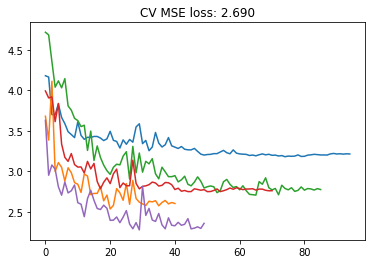

In [35]:
cv = 0.
for l in val_losses:
    plt.plot(l)
    cv += np.min(l)

plt.title(f"CV MSE loss: {cv / len(val_losses):.03f}")

In [36]:
import glob
thermonet_models = [load_model(f) for f in glob.glob(f'{MODELS_PATH}/model*.h5')]

In [37]:
TEST_FEATURES_PATH = '../input/thermonet-features/nesp_features.npy'
if not os.path.exists(TEST_FEATURES_PATH):    
    np.save(thermonet_features(df_test.query('op == "replace"')), 'test_features.npy')
    TEST_FEATURES_PATH = 'test_features.npy'

In [38]:
test_features = np.load(TEST_FEATURES_PATH)
test_features = np.moveaxis(test_features, 1, -1)

In [ ]:
test_ddg = np.stack([model.predict(test_features) for model in thermonet_models])
test_ddg = np.mean(test_ddg, axis=0).flatten()
test_ddg

In [ ]:
df_test.loc[df_test.op == 'replace', 'ddg'] = -test_ddg
df_test.loc[df_test['op'] == "delete", 'ddg'] = df_test[df_test["op"]=="replace"]["ddg"].quantile(q=0.25)
df_test.loc[df_test['op'] == "same", 'ddg'] = 0.
df_test.rename(columns={'ddg': 'tm'})[['seq_id', 'tm']].to_csv('submission.csv', index=False)

In [ ]:
!head submission.csv